# Model V4

Adding 3d support.

The outputs will be the coordinates of the implant application point and the two angles of rotation of the implant (in terms of cosine and sine multiplied by a weight).

The cost function is the mean squared error with the actual values. 

## First step: load and prepare the datasets

Loads the datasets prepared by the `dataset_gen` notebook, then prepare the input by appending all the cross-products.

In [1]:
from dataset_reader import prepare_data_v4

NUM_OF_PERMUTATIONS = 128

input_dataset, output_dataset, perms = prepare_data_v4(num=128)

In [2]:
input_dataset

array([[ -4.81829432,  -1.61782457,  -3.74710129, ...,   3.53329182,
          7.6541306 ,   3.74710129],
       [  4.81829432, -12.58989512,  -5.20399105, ...,  -6.10329682,
          6.03630603,  -3.74710129],
       [  4.81829432,   0.        ,   3.74710129, ...,  -6.10329682,
          6.03630603,  -3.74710129],
       ...,
       [ -4.41813479,  -0.6487417 ,   3.98000285, ...,  -4.98981268,
          7.13787021,  -3.98000285],
       [ -4.41813479, -12.97483409,  -4.58968471, ...,  -4.98981268,
          7.13787021,   3.98000285],
       [ -4.41813479, -13.03790738,   4.96106112, ...,   4.41813479,
          0.        ,   3.98000285]])

In [3]:
output_dataset

array([[ 4.51748619e-03, -7.93068584e-01, -1.55468750e-01, ...,
         0.00000000e+00,  9.87869832e+00,  1.55284241e+00],
       [ 4.51748619e-03, -7.93068584e-01, -1.55468750e-01, ...,
         0.00000000e+00,  9.87869832e+00,  1.55284241e+00],
       [ 4.51748619e-03, -7.93068584e-01, -1.55468750e-01, ...,
         0.00000000e+00,  9.87869832e+00,  1.55284241e+00],
       ...,
       [ 4.31128009e-02, -9.21467627e-01, -4.16549256e-02, ...,
         0.00000000e+00,  9.99029642e+00,  4.40428681e-01],
       [ 4.31128009e-02, -9.21467627e-01, -4.16549256e-02, ...,
         0.00000000e+00,  9.99029642e+00,  4.40428681e-01],
       [ 4.31128009e-02, -9.21467627e-01, -4.16549256e-02, ...,
         0.00000000e+00,  9.99029642e+00,  4.40428681e-01]])

## Now prepare the network

In [4]:
from models import setup_model_v4

model = setup_model_v4(num_not_lin=1, units=1024, order=2, lin_depth=1)
model.summary()

2024-05-24 12:11:15.036512: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Max
2024-05-24 12:11:15.036539: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 64.00 GB
2024-05-24 12:11:15.036544: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 24.00 GB
2024-05-24 12:11:15.036578: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-05-24 12:11:15.036591: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 48)]                 0         []                            
                                                                                                  
 cross_product_layer (Cross  (None, 1224)                 1224      ['input_1[0][0]']             
 ProductLayer)                                                                                    
                                                                                                  
 dense (Dense)               (None, 1024)                 1254400   ['cross_product_layer[0][0]'] 
                                                                                                  
 dropout (Dropout)           (None, 1024)                 0         ['dense[0][0]']           

#### Test the model before training

<tf.Tensor: shape=(1, 7), dtype=float32, numpy=
array([[-1.1730071 , -0.08467364, -1.5892382 , -8.471473  , -5.313583  ,
        -8.711842  , -4.909563  ]], dtype=float32)>

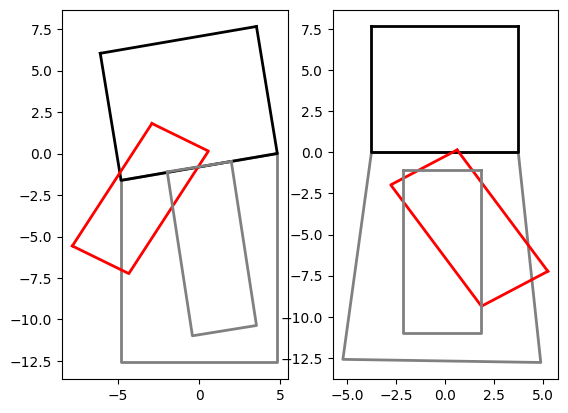

In [5]:

import numpy as np
from second_util import convert_sol
import tensorflow as tf

s1 = input_dataset[10]
orig = output_dataset[10]
perm = perms[10]
import matplotlib.pyplot as plt
from utils import draw_solution_v4

fig = plt.figure()
ax = fig.add_subplot(1, 2, 1)
ax1 = fig.add_subplot(1, 2, 2)

sol = model(tf.convert_to_tensor([s1]))

display(sol)
draw_solution_v4(ax,ax1, prob=s1, sol=sol.numpy(), orig=orig, perm=perm)


### Do the training



In [6]:
from utils import split_input

BATCH_SIZE = 128

(train_x, train_y), (test_x, test_y) = split_input(input_dataset,
                                                   output_dataset)
display(train_x.shape)
display(train_y.shape)


(12096, 48)

(12096, 7)

In [7]:

res = model.fit(x=train_x, y=train_y, batch_size=BATCH_SIZE, epochs=40,
                validation_data=(test_x, test_y))

Epoch 1/40


2024-05-24 12:12:42.491930: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


95/95 [==============================] - 66s 585ms/step - loss: 10.0908 - val_loss: 0.1601
Epoch 2/40
95/95 [==============================] - 20s 208ms/step - loss: 0.1349 - val_loss: 0.0945
Epoch 3/40
95/95 [==============================] - 18s 192ms/step - loss: 0.1033 - val_loss: 0.0785
Epoch 4/40
95/95 [==============================] - 18s 187ms/step - loss: 0.0732 - val_loss: 0.0668
Epoch 5/40
95/95 [==============================] - 17s 182ms/step - loss: 0.0631 - val_loss: 0.0524
Epoch 6/40
95/95 [==============================] - 17s 176ms/step - loss: 0.0574 - val_loss: 0.0596
Epoch 7/40
95/95 [==============================] - 18s 194ms/step - loss: 0.0540 - val_loss: 0.0503
Epoch 8/40
95/95 [==============================] - 17s 176ms/step - loss: 0.0520 - val_loss: 0.0513
Epoch 9/40
95/95 [==============================] - 16s 170ms/step - loss: 0.0555 - val_loss: 0.0601
Epoch 10/40
95/95 [==============================] - 16s 173ms/step - loss: 0.0506 - val_loss: 0.0740

## Plot stats

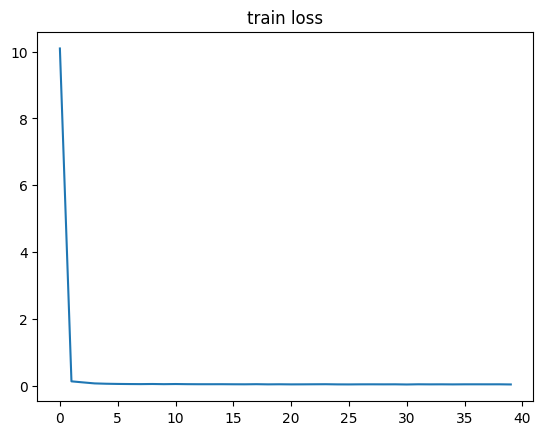

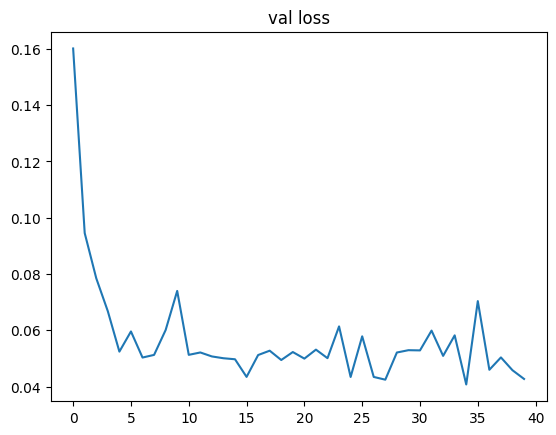

In [8]:
%matplotlib inline


plt.title("train loss")
plt.plot(res.history['loss'])
plt.show()
plt.title("val loss")
plt.plot(res.history['val_loss'])
plt.show()

#### Some random tests

array([[ 3.28198502e-01, -6.10620086e-01,  2.14300561e-01,
        -1.56402588e-04,  5.59736043e-02,  1.22413957e-02,
        -7.99931651e-02]])

array([[ 5.00623176e-01, -3.63574569e-01,  2.35680240e-01,
        -3.28063965e-04,  8.10130313e-02,  3.11689699e-02,
        -2.13245905e-01]])

array([[ 3.81492684e-01, -5.26589577e-01,  6.41327232e-02,
        -2.52723694e-04,  7.11263716e-02,  3.69768465e-02,
        -2.56933606e-01]])

array([[ 2.44643862e-01, -6.55831639e-01,  1.00236352e-01,
        -2.98500061e-04,  7.72254169e-02,  3.08018053e-02,
        -2.10532344e-01]])

array([[ 5.34959862e-01, -5.29722397e-01,  3.95682412e-01,
        -2.49862671e-04,  7.06672221e-02, -2.02557205e-03,
         1.28370160e-02]])

array([[ 0.44650091, -0.25518305,  0.06928819, -0.00067329,  0.11609639,
         0.03684238, -0.25589982]])

array([[ 0.31836397, -0.24549884,  0.18593032, -0.00056744,  0.10652037,
         0.02793506, -0.18952874]])

array([[ 0.46802826, -0.33332569,  0.23479766, -0.00084305,  0.12989153,
         0.03901485, -0.27262048]])

array([[ 4.17425821e-01, -5.59644763e-01,  2.73550928e-02,
        -3.08036804e-04,  7.85123482e-02,  3.14216936e-02,
        -2.15119756e-01]])

array([[ 0.42311336, -0.50128466,  0.30265749, -0.00056458,  0.10618597,
         0.01855377, -0.12301079]])

array([[ 0.31248922, -0.34549755,  0.08308468, -0.00053596,  0.10355387,
         0.00425533, -0.02732018]])

array([[ 0.3096825 , -0.43778593,  0.16260045, -0.00067616,  0.11625323,
         0.03210452, -0.22018281]])

array([[ 2.82222757e-01, -3.83043472e-01,  6.26878917e-02,
        -1.18255615e-04,  4.86397333e-02,  3.16286409e-02,
        -2.16642178e-01]])

array([[ 0.25555588, -0.36349839,  0.09680499, -0.00101089,  0.14218819,
         0.04012683, -0.28126708]])

array([[ 1.09384263e-01, -6.24877755e-01,  1.68678992e-01,
        -3.14712524e-04,  7.92809874e-02,  4.33531130e-02,
        -3.06689895e-01]])

array([[ 1.56565959e-01, -6.23198573e-01,  9.54614311e-02,
        -1.37329102e-04,  5.24047576e-02,  1.54209459e-02,
        -1.01493395e-01]])

array([[ 5.09002516e-01, -4.50639788e-01,  1.04450005e-01,
        -4.11033630e-04,  9.06333104e-02,  4.78620851e-02,
        -3.43136347e-01]])

array([[ 0.34506548, -0.31767482,  0.11981979, -0.00091267,  0.13517217,
         0.03255084, -0.22350792]])

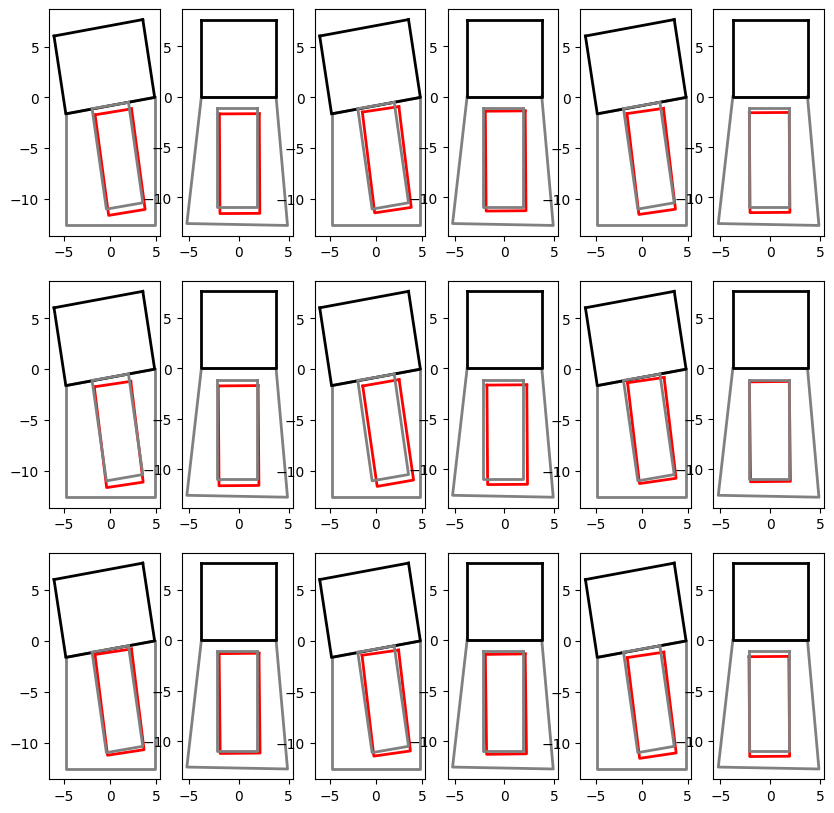

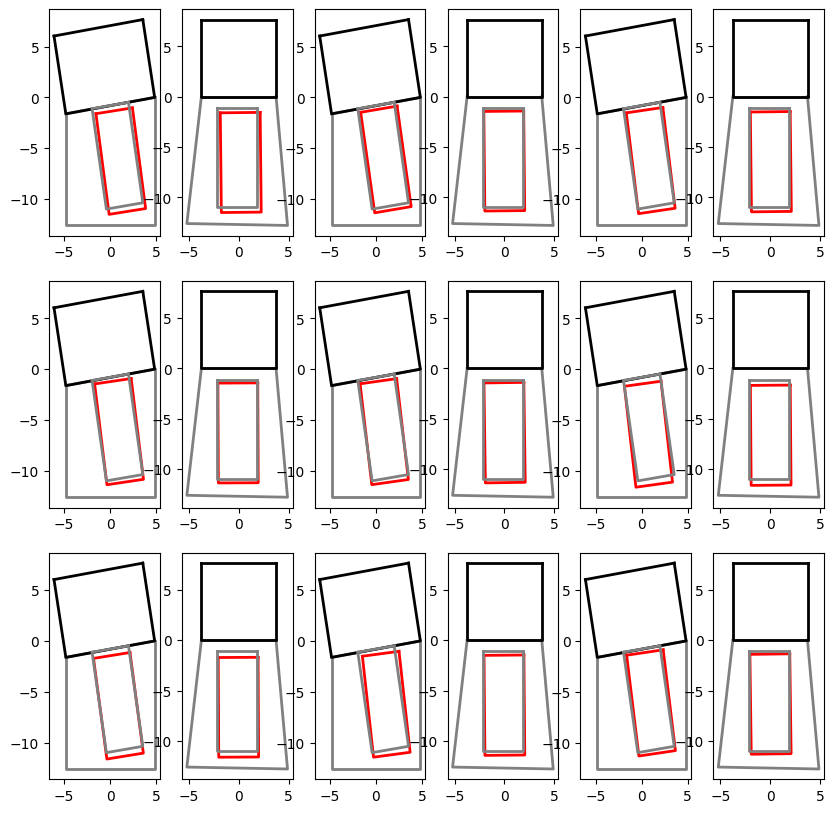

In [20]:
from typing import Callable, List
import matplotlib.pyplot as plt
from utils import draw_solution_v4


def draw_many(model,nums:List[int]):
    fig = plt.figure(figsize=(10,10))
    for i,n in zip(range(len(nums)),nums):
        
        s1 = input_dataset[n]
        orig = output_dataset[n]
        perm = perms[n]
        
        
        ax = fig.add_subplot(int(len(nums)/3), 6, 1+i*2)
        ax1 = fig.add_subplot(int(len(nums)/3), 6, 2+i*2)
        
        sol = model(tf.convert_to_tensor([s1]))
        
        display(sol.numpy()-orig)
        draw_solution_v4(ax,ax1, prob=s1, sol=sol.numpy(), orig=orig, perm=perm)


draw_many(model,list(range(9)))
draw_many(model,list(range(9,18)))


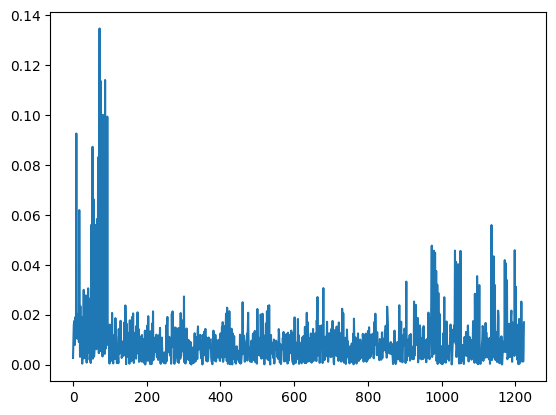

In [11]:
plt.plot(np.abs(model.weights[0].numpy()))

In [12]:
from utils import datadir

model.save(datadir("model_v4_prod_v1"))

INFO:tensorflow:Assets written to: /Users/vittorio/Projects/Implantmaster.ai/prototype1/data/model_v4_prod_v1/assets


INFO:tensorflow:Assets written to: /Users/vittorio/Projects/Implantmaster.ai/prototype1/data/model_v4_prod_v1/assets
